In [15]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.ioff()
from skimage import io
from skimage.draw import disk, circle_perimeter
import pandas as pd
import numpy as np
from os import path
base_path = "/media/ula/DATADRIVE1/fos_gfp_tmaze/ctx_landmark/despeckle/"
res_dir_path = base_path + "alignment_result/"
dir_path = res_dir_path + "aligned_despeckle/"
cell_data_fn_template = "m{}r{}_{}_output.txt"
img_fn_template = "m{}r{}_{}.tif"
xcolname = "Intensity center X (px) (ch 0)"
ycolname = "Intensity center Y (px) (ch 0)"
zcolname = "Intensity center Z (px) (ch 0)"
roi_diameter = [8,7,4]
xy_scale = 1.19;
z_scale = 2;
tolerance = 4

In [265]:
landmark_first_mice = [1, 3, 4, 6,7,9,12,15,17, 18]
landmark_first_mice = [1,3,17, 4]
ctx_first_mice = [2,5,8,10,11,13,14,16,19,20]
ctx_first_mice = [2, 5,10,11]
ctx_session_order = ["ctx", "landmark1", "landmark2"]
landmark_session_order = ["landmark", "ctx1", "ctx2"]

max_region_no = 4

In [17]:
#transferred
def calculate_intensity(center_x, center_y, center_z, img):
    center_x = int(round(center_x))
    center_y = int(round(center_y))
    center_z = int(round(center_z))
    sum_int = 0
    area_int = 0
    for i in range(-2,3):
        if(center_z+i >= 0 and center_z+i < img.shape[0]):
            diameter = roi_diameter[abs(i)]
            rad = diameter//2
            disk_ = disk((center_y, center_x), rad, shape=img[0].shape)
            sum_int += np.sum(img[center_z+i][disk_])
            area_int += len(img[center_z+i][disk_])
    return sum_int/area_int

In [4]:
#transferred
def update_intensity_for_df(df, img):
    df["intensity_standarized"] = df.apply(lambda row : calculate_intensity(row[xcolname],
                     row[ycolname], row[zcolname], img), axis = 1)
    return df[df['Mean Intensity (ch 0)']/df['intensity_standarized']<=1.5]

In [5]:
#transferred
def rescale_df(df):
    df[xcolname] = df[xcolname]*xy_scale
    df[ycolname] = df[ycolname]*xy_scale
    df[zcolname] = df[zcolname]*z_scale
    return df

In [6]:
def calculate_overlap(df1, df2):
    res_df = pd.DataFrame(columns=["idx1", "idx2", "intensity1", "intensity2"])
    multiple_algs = 0
    for idx1, row1 in df1.iterrows():
        rep_counter = 0
        for idx2, row2 in df2.iterrows():
            dist = np.linalg.norm(row1[xcolname:zcolname]-row2[xcolname:zcolname])
            if dist < tolerance:
                rep_counter += 1
                if rep_counter == 2:
                    multiple_algs+=1
                elif rep_counter == 1:
                    res_df = res_df.append({"idx1":idx1, "idx2" :idx2, 
                                            "intensity1":row1['intensity_standarized'], 
                                            "intensity2":row2['intensity_standarized']},
                                           ignore_index=True)
    return res_df

In [7]:
def find_fluorescence_profile(row, bgrs):
    row_i0 = row.i0 - bgrs[0]
    row_i1 = row.i1 - bgrs[1]
    row_i2 = row.i2 - bgrs[2]
    if row_i1 > row_i0 and row_i2 > row_i0:
        return 'a'
    elif row_i1 < row_i0 and row_i2 < row_i0:
        return 'b'
    else:
        return 'c'

In [8]:
def find_persistent_cells(rdf1, rdf2, bgrs):
    persistent = rdf1.join(rdf2.set_index("idx1"), on="idx1", how="inner", rsuffix="_r")
    ordered = pd.DataFrame(columns=["i0", "i1", "i2"])
    ordered.i0 = persistent.intensity2
    ordered.i1 = persistent.intensity1
    ordered.i2 = persistent.intensity2_r
    ordered["fluo_type"] = ordered.apply(lambda row : find_fluorescence_profile(row, bgrs), axis = 1)
    ordered.to_csv(dir_path + cell_data_fn_template.format(mouse, region, "ordered"))

In [214]:
def find_background_intensities(df_array):
    res = np.array([])
    for i in range(len(df_array)):
        df = df_array[i]
        background_cells = df[df.intensity_standarized<df.intensity_standarized.quantile(0.25)]
        res=np.append(res, background_cells.describe().intensity_standarized['mean'])
    print(res)
    return res

In [10]:
def compare_sessions(mouse, region, session_order):
    df_array={}
    img_array={}
    for i in range(len(session_order)):
        df_array[i] = pd.read_csv(dir_path + cell_data_fn_template
                                  .format(mouse, region, session_order[i]), "\t", header=1)
        img_array[i] =  io.imread(dir_path + img_fn_template
                                  .format(mouse, region, session_order[i])).astype("uint8")
        
    for i in range(len(session_order)):
        df_array[i] = df_array[i][df_array[i]['Interior (px)']>30]
        df_array[i] = update_intensity_for_df(df_array[i], img_array[i])
        df_array[i] = rescale_df( df_array[i])
        
    bgrs = find_background_intensities(df_array)
    #tutaj b wazna kolejnosc!!!   
    rdf1 = calculate_overlap(df_array[1], df_array[0])  
    rdf1.to_csv(dir_path + cell_data_fn_template
                .format(mouse, region, session_order[1]+"_"+session_order[0]))
    rdf2 = calculate_overlap(df_array[1], df_array[2])
    rdf2.to_csv(dir_path + cell_data_fn_template
                .format(mouse, region, session_order[1]+"_"+session_order[2]))
    find_persistent_cells(rdf1, rdf2, bgrs)
    return rdf1, rdf2


In [204]:
session_order = ctx_session_order

s12 = pd.DataFrame()
s23 = pd.DataFrame()
s21 = pd.DataFrame()
s32 = pd.DataFrame()

for mouse in ctx_first_mice:
    for region in [1,2]:
        df_array={}
        img_array={}
        
        pathname = dir_path + cell_data_fn_template.format(mouse, region, session_order[i])
        if path.exists(pathname):
            for i in range(len(session_order)):
                df_array[i] = pd.read_csv(dir_path + cell_data_fn_template
                                          .format(mouse, region, session_order[i]), "\t", header=1)
                img_array[i] =  io.imread(dir_path + img_fn_template
                                          .format(mouse, region, session_order[i])).astype("uint8")
            for i in range(len(session_order)):
                df_array[i] = df_array[i][df_array[i]['Interior (px)']>30]
                df_array[i] = update_intensity_for_df(df_array[i], img_array[i])
            rdf1 = pd.read_csv(dir_path + cell_data_fn_template
                               .format(mouse, region, session_order[1]+"_"+session_order[0]))    
            rdf2 = pd.read_csv(dir_path + cell_data_fn_template
                               .format(mouse, region, session_order[1]+"_"+session_order[2]))

            bgrs = find_background_intensities(df_array)

            df_arr = df_array[0][['intensity_standarized']]-bgrs[0]
            df_arr = df_arr.join(rdf1.set_index("idx2"), rsuffix="_rdf")
            df_arr[["intensity1"]] = df_arr[["intensity1"]] -bgrs[1]
            df_arr[["intensity1"]] = df_arr[["intensity1"]].fillna(0)
            s12 = s12.append(df_arr)
            
            df_arr2 = df_array[1][['intensity_standarized']]-bgrs[1]
            df_arr2 = df_arr2.join(rdf2.set_index("idx1"), rsuffix="_rdf")
            df_arr2[["intensity2"]] = df_arr2[["intensity2"]] -bgrs[2]
            df_arr2[["intensity2"]] = df_arr2[["intensity2"]].fillna(0)
            s23 = s23.append(df_arr2)
            
            df_arr3 = df_array[1][['intensity_standarized']]-bgrs[1]
            df_arr3 = df_arr3.join(rdf1.set_index("idx1"), rsuffix="_rdf")
            df_arr3[["intensity2"]] = df_arr3[["intensity2"]] - bgrs[0]
            df_arr3[["intensity2"]]  = df_arr3[["intensity2"]].fillna(0)
            s21 = s21.append(df_arr3)

            df_arr4 = df_array[2][['intensity_standarized']] - bgrs[2]
            df_arr4 = df_arr4.join(rdf2.set_index("idx2"), rsuffix="_rdf")
            df_arr4[["intensity1"]] = df_arr4[["intensity1"]] - bgrs[0]
            df_arr4[["intensity1"]] = df_arr3[["intensity1"]].fillna(0)
            s32 = s32.append(df_arr4)
        
        

[22.69156054 16.29791759 11.90203379]
[10.53886522 13.35015588 11.43020507]
[4.64860042 7.39221292 6.79382328]
[18.83724651 18.71561639 14.66422747]
[22.15361477 20.21741761 17.05058571]
[11.3144057  10.05624907 12.6202683 ]
[5.15905445 4.23258954 4.09954784]


In [37]:
tmp = s12[s12.intensity_standarized>s12.intensity_standarized.quantile(0.9)]
plt.bar(['top c avg intensity in c', 'top c avg intensity in l'],
    [np.mean(tmp.intensity_standarized), np.mean(tmp.intensity1)])
plt.ylim(0,100)
plt.show()
tmp = s21[s21.intensity_standarized>s21.intensity_standarized.quantile(0.9)]

plt.bar(['top l avg intensity in l', 'top l avg intensity in c'],
    [np.mean(tmp.intensity_standarized), np.mean(tmp.intensity2)])

plt.ylim(0,100)
plt.show()
tmp = s23[s23.intensity_standarized>s23.intensity_standarized.quantile(0.9)]

plt.bar(['top l1 avg intensity in l1', 'top l1 avg intensity in l2'],
    [np.mean(tmp.intensity_standarized), np.mean(tmp.intensity2)])
plt.ylim(0,100)
plt.show()
tmp = s32[s32.intensity_standarized>s32.intensity_standarized.quantile(0.9)]
plt.bar(['top l2 avg intensity in l2', 'top l2 avg intensity in l1'],
    [np.mean(tmp.intensity_standarized), np.mean(tmp.intensity2)])
plt.ylim(0,100)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'intensity_standarized'

In [294]:
session_order = landmark_session_order

s12 = pd.DataFrame()
s23 = pd.DataFrame()
s21 = pd.DataFrame()
s32 = pd.DataFrame()
#pw - population wide brightest
percentages = {"pw12":np.array([]),'brightest12':np.array([]),
              "pw23":np.array([]), 'brightest23':np.array([])}

for mouse in landmark_first_mice:
    for region in [1,2]:
        df_array={}
        img_array={}
        
        pathname = dir_path + cell_data_fn_template.format(mouse, region, session_order[1]+"_"+session_order[2])
        if path.exists(pathname):
            for i in range(len(session_order)):
                df_array[i] = pd.read_csv(dir_path + cell_data_fn_template
                                          .format(mouse, region, session_order[i]), "\t", header=1)
                img_array[i] =  io.imread(dir_path + img_fn_template
                                          .format(mouse, region, session_order[i])).astype("uint8")
            for i in range(len(session_order)):
                df_array[i] = df_array[i][df_array[i]['Interior (px)']>30]
                df_array[i] = update_intensity_for_df(df_array[i], img_array[i])
            rdf1 = pd.read_csv(dir_path + cell_data_fn_template
                               .format(mouse, region, session_order[1]+"_"+session_order[0]))    
            rdf2 = pd.read_csv(dir_path + cell_data_fn_template
                               .format(mouse, region, session_order[1]+"_"+session_order[2]))

            bgrs = find_background_intensities(df_array)
            
            brightest_quantile = 0.95
            
            first_session = df_array[0][['intensity_standarized']]-bgrs[0]
            first_session_brightest = first_session[first_session.intensity_standarized >
                                               first_session.intensity_standarized.quantile(brightest_quantile)]
            
            mid_session = df_array[1][['intensity_standarized']]-bgrs[1]
            mid_session_brightest = mid_session[mid_session.intensity_standarized >
                                               mid_session.intensity_standarized.quantile(brightest_quantile)]
            
            
            
            
            df_arr = first_session_brightest[['intensity_standarized']]-bgrs[0]
            df_arr = df_arr.join(rdf1.set_index("idx2"), rsuffix="_rdf")
            df_arr[["intensity1"]] = df_arr[["intensity1"]] -bgrs[1]
            strongest_session1 = df_arr[["intensity1"]].dropna().shape[0]
            df_arr[["intensity1"]] = df_arr[["intensity1"]].fillna(0)
            s12 = s12.append(df_arr)
            
            df_arr2 = mid_session_brightest[['intensity_standarized']]-bgrs[1]
            df_arr2 = df_arr2.join(rdf2.set_index("idx1"), rsuffix="_rdf")
            df_arr2[["intensity2"]] = df_arr2[["intensity2"]] -bgrs[2]
            strongest_session2 = df_arr2[["intensity2"]].dropna().shape[0]
            df_arr2[["intensity2"]] = df_arr2[["intensity2"]].fillna(0)
            s23 = s23.append(df_arr2)

            percentages["pw12"] = np.append(percentages["pw12"], rdf1.shape[0]/df_array[0].shape[0])
            percentages["pw23"] = np.append(percentages["pw23"], rdf2.shape[0]/df_array[1].shape[0])
            percentages["brightest12"] = np.append(percentages["brightest12"], 
                                                   strongest_session1/first_session_brightest.shape[0])
            percentages["brightest23"] = np.append(percentages["brightest23"], 
                                                   strongest_session2/mid_session_brightest.shape[0])
   



[8.42384025 8.29629474 6.96897096]
[13.20058079  9.3439466   8.29305542]
[39.73972293 25.71240074 27.46358666]
[25.49749679 20.56442869 15.42730575]
[27.62049216 28.63772875 19.92224794]
[14.9513217  21.30521739 16.57538946]


<IPython.core.display.Javascript object>


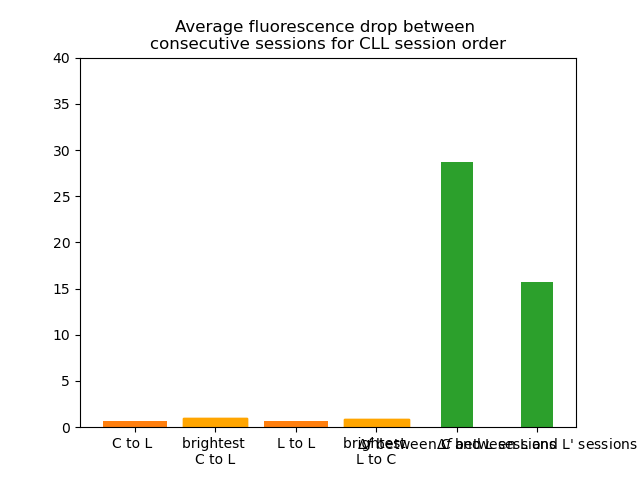

In [295]:
plt.bar([r'$\Delta f$ between C and L sessions', '$\Delta f$ between L and L\' sessions'], [np.mean(s12.intensity_standarized - s12.intensity1),
                             np.mean(s23.intensity_standarized - s23.intensity2)
                                ], width = 0.4)
plt.ylim(0, 40)
plt.title("Average fluorescence drop between \nconsecutive sessions for CLL session order")
plt.show()

In [292]:
percentages_cll = percentages

<ipython-input-301-438fdf154fbf>:17: UserWarning: Legend does not support 'all cells from the session' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(['all cells from the session'], ['cells over 0.95 intensity quantile'])


<IPython.core.display.Javascript object>


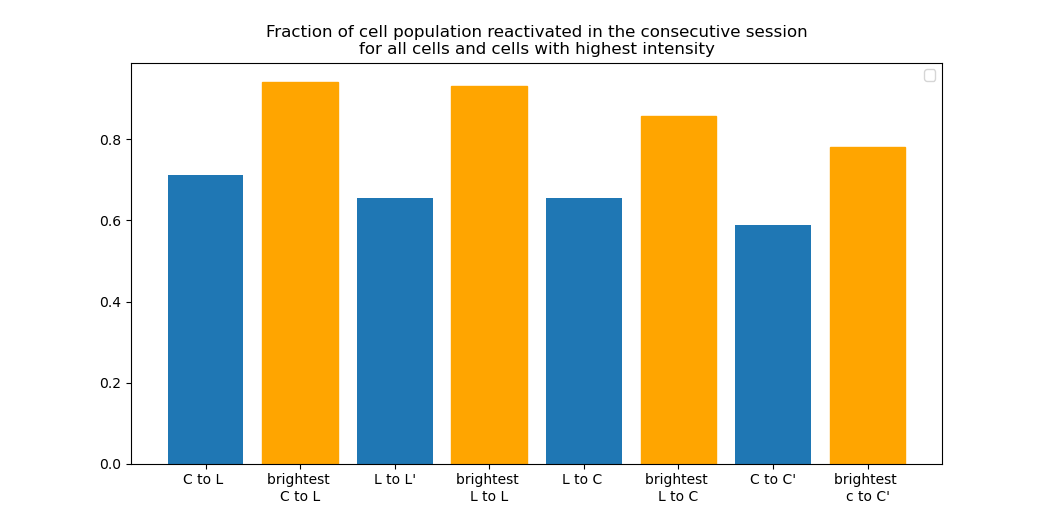

In [301]:
plt.title('Fraction of cell population reactivated in the consecutive session\nfor all cells and cells with highest intensity')
barlist= plt.bar(['C to L ', 
         'brightest \nC to L', 
         'L to L\'', 
         'brightest \nL to L',
                 'L to C ', 
         'brightest \nL to C', 
         'C to C\'', 
         'brightest \nc to C\''], [np.mean(percentages_cll["pw12"]),
                                                             np.mean(percentages_cll["brightest12"]),
                                                             np.mean(percentages_cll["pw23"]),
                                                             np.mean(percentages_cll["brightest23"]),
                                                             np.mean(percentages["pw12"]),
                                                             np.mean(percentages["brightest12"]),
                                                             np.mean(percentages["pw23"]),
                                                             np.mean(percentages["brightest23"])])
plt.legend(['all cells from the session'], ['cells over 0.95 intensity quantile'])
for i in [1,3,5,7]:
    barlist[i].set_color('orange')
plt.show()

<IPython.core.display.Javascript object>


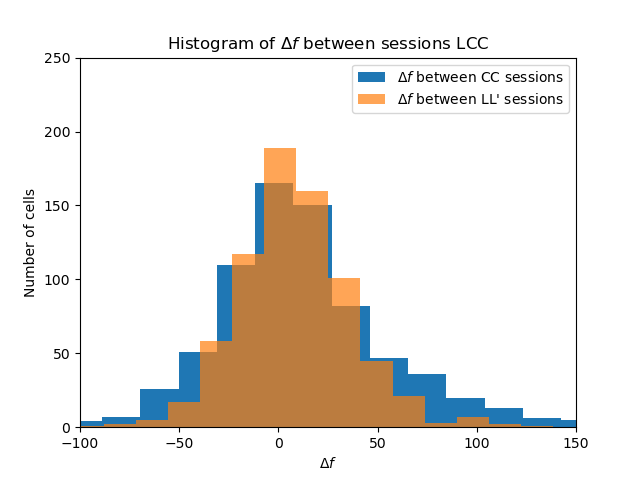

In [284]:
plt.hist(s12.intensity_standarized - s12.intensity1, 15)

plt.xlim(-100, 150)
plt.ylim(-0, 250)
plt.xlabel("$\Delta f$")
plt.ylabel("Number of cells")

plt.title("Histogram of $\Delta f$ between sessions LCC")
plt.hist(s23.intensity_standarized - s23.intensity2, 15, alpha=0.7)
plt.legend(["$\Delta f$ between CC sessions","$\Delta f$ between LL\' sessions"])

plt.show()


<IPython.core.display.Javascript object>


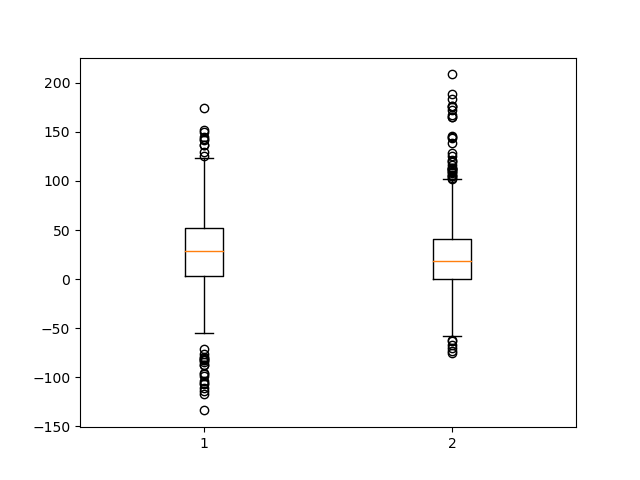

In [159]:
plt.boxplot([s12.intensity_standarized - s12.intensity1,
             s23.intensity_standarized - s23.intensity2])
plt.show()

In [215]:
summary_df = {}
session_order = landmark_session_order
for i in range(len(landmark_session_order)):
    summary_df[i]=pd.DataFrame()

for mouse in landmark_first_mice:
    for region in [1,2]:
        df_array={}
        img_array={}
        
        pathname = dir_path + cell_data_fn_template.format(mouse, region, session_order[i])
        if path.exists(pathname):
            for i in range(len(session_order)):
                df_array[i] = pd.read_csv(dir_path + cell_data_fn_template
                                          .format(mouse, region, session_order[i]), "\t", header=1)
                img_array[i] =  io.imread(dir_path + img_fn_template
                                          .format(mouse, region, session_order[i])).astype("uint8")
            for i in range(len(session_order)):
                df_array[i] = df_array[i][df_array[i]['Interior (px)']>30]
                df_array[i] = update_intensity_for_df(df_array[i], img_array[i])
            bgrs = find_background_intensities(df_array)
            for i in range(len(session_order)):
                df = df_array[i] - bgrs[i]
                df_array[i] = df[df.intensity_standarized>
                                         df.intensity_standarized.quantile(0.95)]
                summary_df[i] = summary_df[i].append(df_array[i])

[8.42384025 8.29629474 6.96897096]
[13.20058079  9.3439466   8.29305542]
[39.73972293 25.71240074 27.46358666]
[25.49749679 20.56442869 15.42730575]
[27.62049216 28.63772875 19.92224794]
[14.9513217  21.30521739 16.57538946]


<IPython.core.display.Javascript object>


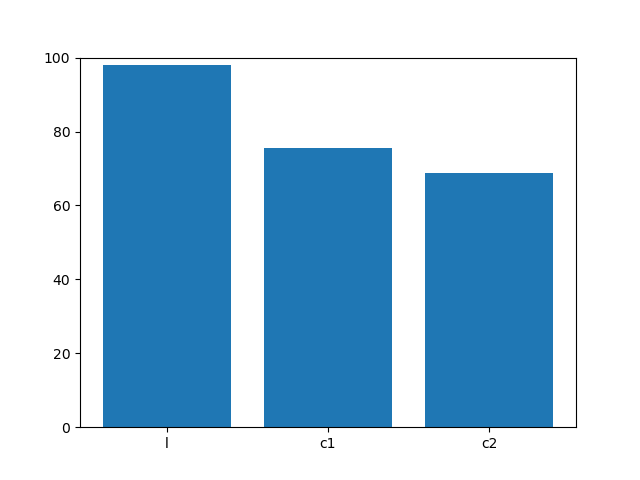

In [216]:
plt.bar(['l', 'c1', 'c2'], [np.mean(summary_df[0].intensity_standarized),
                            np.mean(summary_df[1].intensity_standarized),
                          np.mean(summary_df[2].intensity_standarized)])
plt.ylim(0,100)
plt.show()

[8.42384025 8.29629474 6.96897096]
[0.24876847 0.37438424 0.37438424 0.2044335 ]
[0.24918033 0.37377049 0.37377049 0.19344262]
[0.24918033 0.37377049 0.36229508 0.18196721]
[0.24876847 0.37438424 0.26600985 0.13300493]


<IPython.core.display.Javascript object>


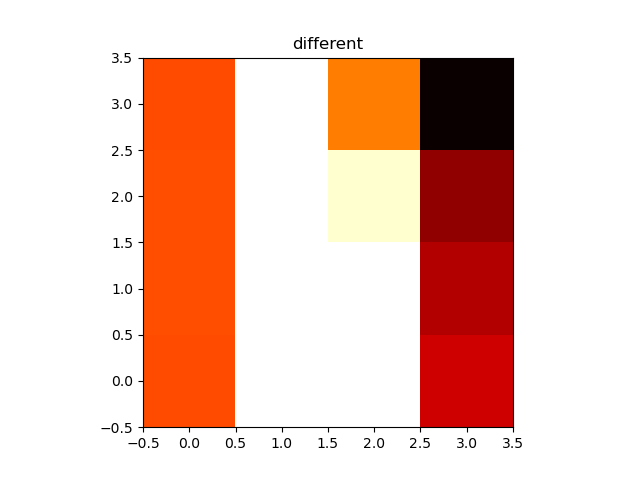

<IPython.core.display.Javascript object>


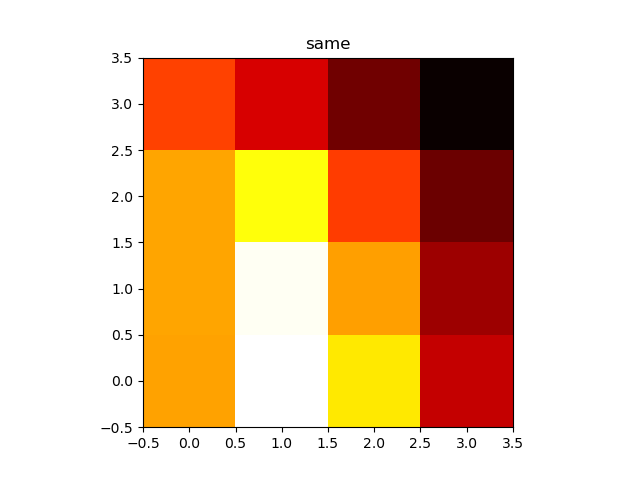

[13.20058079  9.3439466   8.29305542]
[0.24853229 0.37377691 0.37377691 0.21526419]
[0.24869792 0.375      0.375      0.20572917]
[0.24836601 0.37385621 0.36993464 0.18562092]
[0.24804688 0.375      0.26757812 0.13085938]


<IPython.core.display.Javascript object>


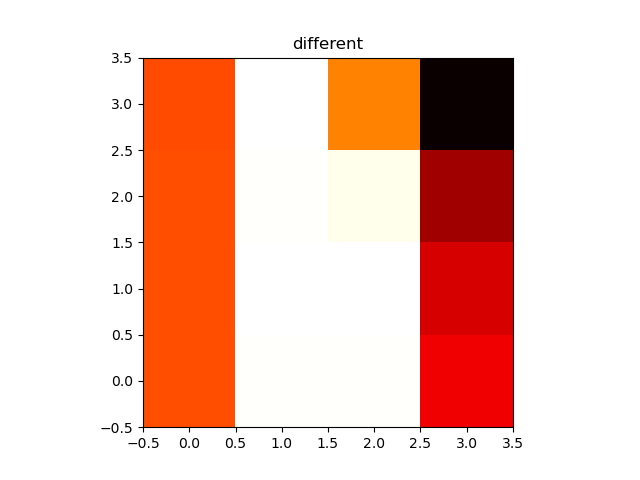

<IPython.core.display.Javascript object>


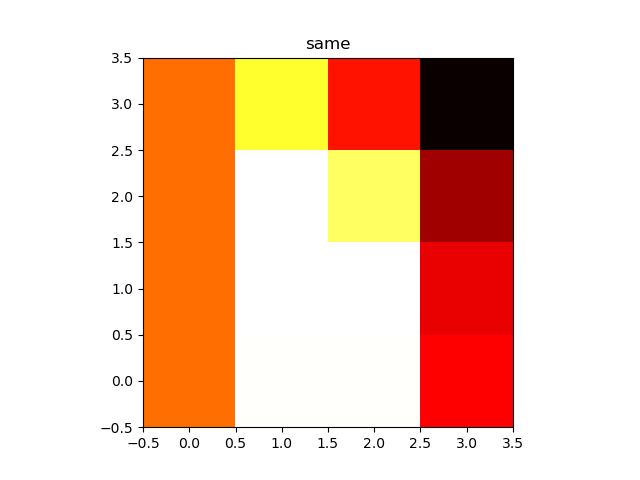

[39.73972293 25.71240074 27.46358666]
[0.24918567 0.37459283 0.34690554 0.1742671 ]
[0.2494577  0.37418655 0.31561822 0.15835141]
[0.2494577  0.37418655 0.27114967 0.13557484]
[0.24918567 0.26221498 0.1742671  0.08794788]


<IPython.core.display.Javascript object>


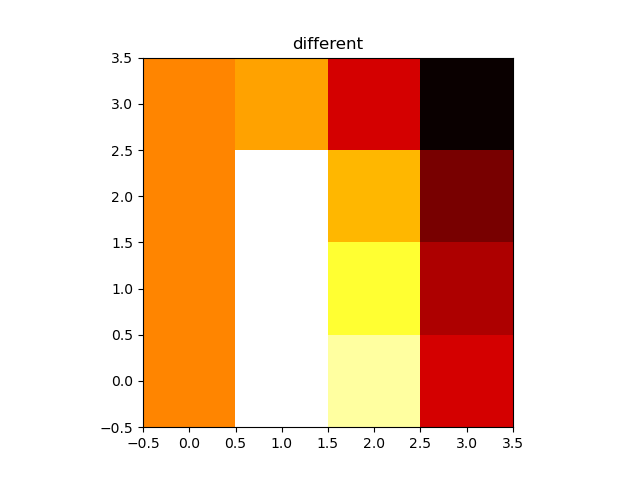

<IPython.core.display.Javascript object>


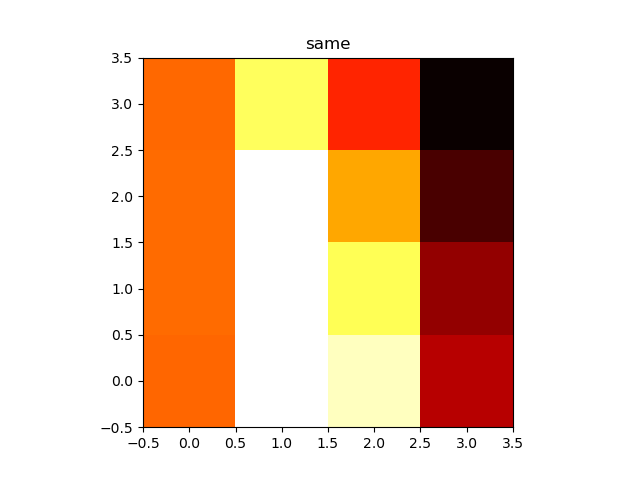

[25.49749679 20.56442869 15.42730575]
[0.24911661 0.3745583  0.28975265 0.14487633]
[0.24941176 0.37411765 0.25294118 0.12705882]
[0.24941176 0.31176471 0.20823529 0.10470588]
[0.21164021 0.15873016 0.10582011 0.05291005]


<IPython.core.display.Javascript object>


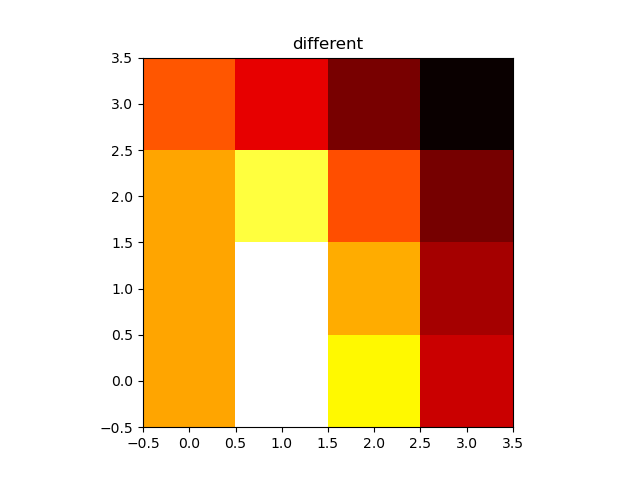

<IPython.core.display.Javascript object>


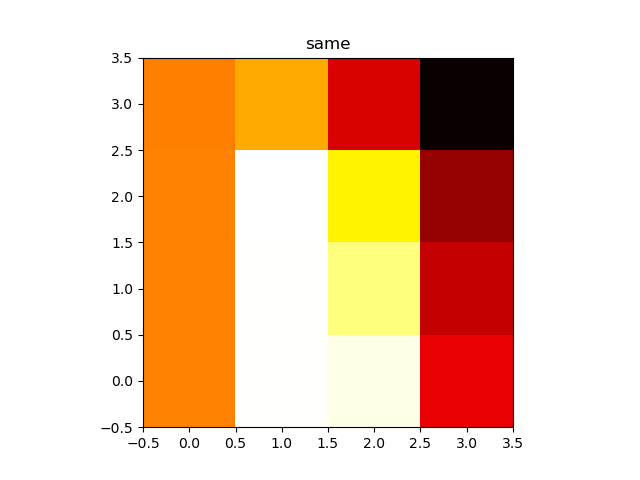

[27.62049216 28.63772875 19.92224794]
[0.24828767 0.375      0.375      0.23116438]
[0.24885845 0.37442922 0.37328767 0.21004566]
[0.24885845 0.37442922 0.34931507 0.17351598]
[0.24828767 0.375      0.26883562 0.13527397]


<IPython.core.display.Javascript object>


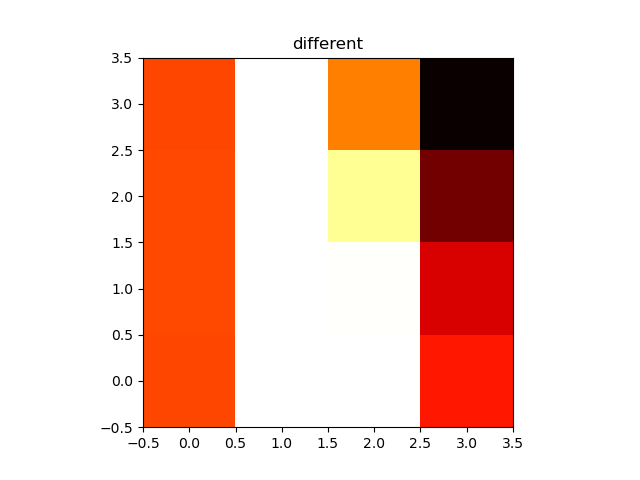

<IPython.core.display.Javascript object>


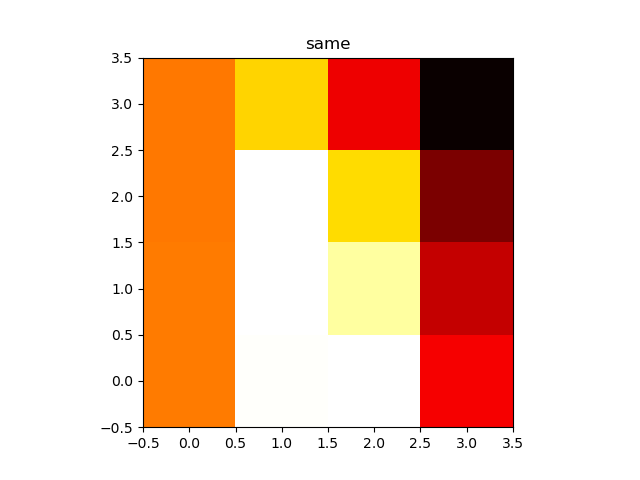

[14.9513217  21.30521739 16.57538946]
[0.24918567 0.37459283 0.37459283 0.22801303]
[0.24864278 0.37350706 0.37459283 0.21606949]
[0.24864278 0.37459283 0.37459283 0.18783931]
[0.24836601 0.37418301 0.3120915  0.15686275]


<IPython.core.display.Javascript object>


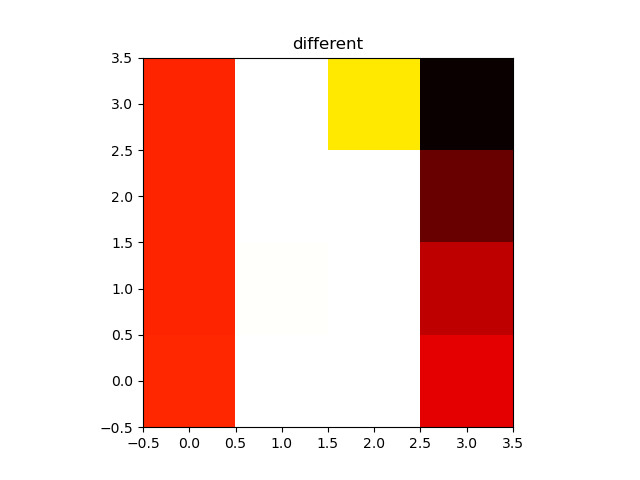

<IPython.core.display.Javascript object>


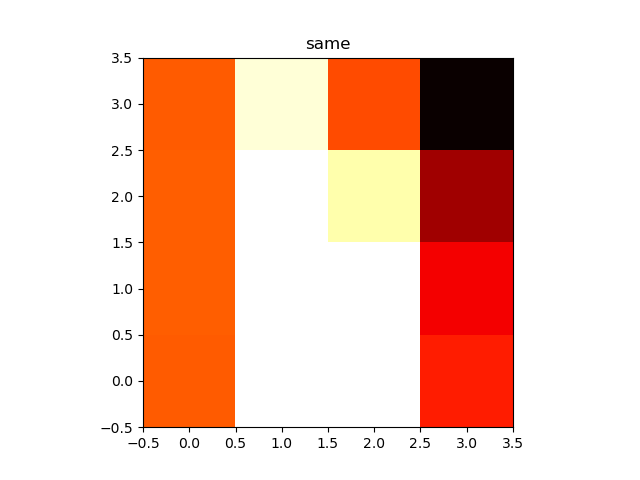

In [263]:
session_order = landmark_session_order

s12 = pd.DataFrame()
s23 = pd.DataFrame()
s21 = pd.DataFrame()
s32 = pd.DataFrame()
#pw - population wide brightest

for mouse in landmark_first_mice:
    for region in [1,2]:
        df_array={}
        img_array={}
        reactivation_matrix = np.zeros((4,4))
        reactivation_matrix2 = np.zeros((4,4))
        
        pathname = dir_path + cell_data_fn_template.format(mouse, region, session_order[1]+"_"+session_order[2])
        if path.exists(pathname):
            for i in range(len(session_order)):
                df_array[i] = pd.read_csv(dir_path + cell_data_fn_template
                                          .format(mouse, region, session_order[i]), "\t", header=1)
                img_array[i] =  io.imread(dir_path + img_fn_template
                                          .format(mouse, region, session_order[i])).astype("uint8")
            for i in range(len(session_order)):
                df_array[i] = df_array[i][df_array[i]['Interior (px)']>30]
                df_array[i] = update_intensity_for_df(df_array[i], img_array[i])
            rdf1 = pd.read_csv(dir_path + cell_data_fn_template
                               .format(mouse, region, session_order[1]+"_"+session_order[0]))    
            rdf2 = pd.read_csv(dir_path + cell_data_fn_template
                               .format(mouse, region, session_order[1]+"_"+session_order[2]))

            bgrs = find_background_intensities(df_array)
            
            brightest_quantile = 0.95
            
            first_session = df_array[0][['intensity_standarized']]-bgrs[0]
            first_session_brightest = first_session[first_session.intensity_standarized >
                                               first_session.intensity_standarized.quantile(brightest_quantile)]
            
            mid_session = df_array[1][['intensity_standarized']]-bgrs[1]
            mid_session_brightest = mid_session[mid_session.intensity_standarized >
                                               mid_session.intensity_standarized.quantile(brightest_quantile)]
            
            
            
            
            df_arr = df_array[0][['intensity_standarized']]
            df_arr = df_arr.join(rdf1.set_index("idx2"))
            df_arr = df_arr.set_index("idx1").join(df_array[1][['intensity_standarized']], rsuffix='_later') 
            df_arr = df_arr.fillna(0)
            all_cells = df_arr.shape[0]
            
            for i in range(4):
                tmp = df_arr[df_arr.intensity_standarized 
                                 > df_arr.intensity_standarized.quantile(1-0.25*(i+1))]
                tmp = tmp[tmp.intensity_standarized 
                                 < tmp.intensity_standarized.quantile(1-0.25*(i))]
                
                all_cells = tmp.shape[0]
                for j in range(4):
                    tmp2 = tmp[tmp.intensity_standarized_later 
                                 > tmp.intensity_standarized_later.quantile(1-0.25*(j+1))]
                    tmp2 = tmp2[tmp2.intensity_standarized_later 
                                 <tmp2.intensity_standarized_later.quantile(1-0.25*(j))]
                    reactivation_matrix[i][j] += tmp2.shape[0]/all_cells
                print(reactivation_matrix[i])

            
            df_arr2 = df_array[1][['intensity_standarized']]
            df_arr2 = df_arr2.join(rdf2.set_index("idx1"))
            df_arr2 = df_arr2.set_index("idx2").join(df_array[2][['intensity_standarized']], rsuffix='_later') 
            df_arr2 = df_arr2.fillna(0)
            all_cells = df_arr2.shape[0]
            
            for i in range(4):
                tmp = df_arr2[df_arr2.intensity_standarized 
                                 > df_arr2.intensity_standarized.quantile(1-0.25*(i+1))]
                tmp = tmp[tmp.intensity_standarized 
                                 < tmp.intensity_standarized.quantile(1-0.25*(i))]
                
                all_cells = tmp.shape[0]
                for j in range(4):
                    tmp2 = tmp[tmp.intensity_standarized_later 
                                 > tmp.intensity_standarized_later.quantile(1-0.25*(j+1))]
                    tmp2 = tmp2[tmp2.intensity_standarized_later 
                                 <tmp2.intensity_standarized_later.quantile(1-0.25*(j))]
                    reactivation_matrix2[i][j] += tmp2.shape[0]/all_cells
            plt.title("different")
            plt.imshow(reactivation_matrix, cmap='hot', interpolation='nearest')
            ax=plt.gca()
            ax.set_ylim(-0.5,3.5)
            plt.show()
            plt.title("same")
            plt.imshow(reactivation_matrix2, cmap='hot', interpolation='nearest')
            ax=plt.gca()
            ax.set_ylim(-0.5,3.5)
            plt.show()
           

In [264]:
print(reactivation_matrix2)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


<IPython.core.display.Javascript object>


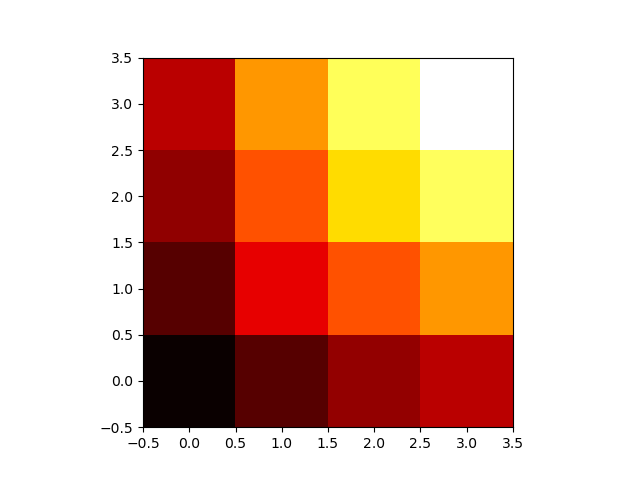

<IPython.core.display.Javascript object>


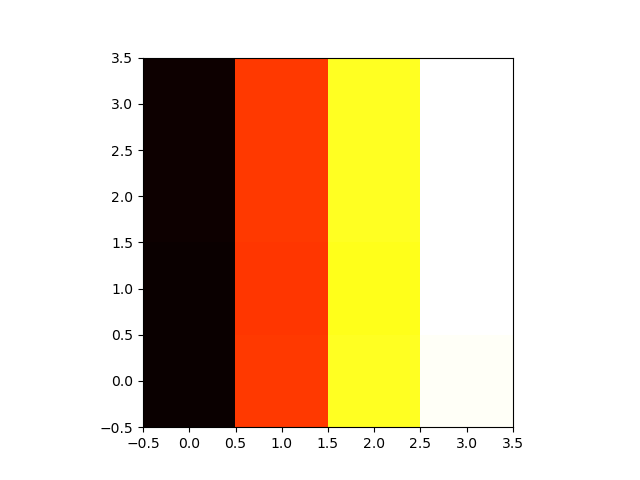

In [251]:
plt.imshow(reactivation_matrix/6, cmap='hot', interpolation='nearest')
ax=plt.gca()
ax.set_ylim(-0.5,3.5)
plt.show()
plt.imshow(reactivation_matrix2/6, cmap='hot', interpolation='nearest')
ax=plt.gca()
ax.set_ylim(-0.5,3.5)
plt.show()

In [207]:
landmark_first_mice

[1, 3, 17, 4]

In [310]:
summ = 0
session_order = ctx_session_order
for mouse in ctx_first_mice:
    for region in [1,2]:
        df_array={}
        img_array={}
        pathname = dir_path + cell_data_fn_template.format(mouse, region, session_order[1]+"_"+session_order[2])
        if path.exists(pathname):
            for i in range(len(session_order)):
                df_array[i] = pd.read_csv(dir_path + cell_data_fn_template
                                          .format(mouse, region, session_order[i]), "\t", header=1)
                summ += df_array[i].shape[0]

In [311]:
summ

52561